<a href="https://colab.research.google.com/github/AfrozSaqlain/Physics-Informed-Neural-Network/blob/main/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [309]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# What are PINNs?

Physics-Informed Neural Networks (PINNs) are a type of neural network that incorporatees phyical laws described by partial differential equations (PDEs) into the learning process. Unlike traditional neural networks that rely purely on data, PINNs leverage the governing equations of the system to inform the training process.

## Universal Approximation Theorem

The Universal Approximation Theorem states that a simple neural network with at least one hidden layer and finite number of neurons can approximate any continuous function, on a closed and bounded interval to any desired level of accuracy, given enough neurons in the hidden layer and appropriate activation functions.

# Concept of PINNs

## Traditional ML vs PINNs

In traditional machine learning, models are trained using datasets consisting of input-output pairs, (X, y). The model learns to map X to y by minimizing error between its predictions and the true output features.

In contrast, PINNs do not rely on a traditional dataset. Instead, they are trained using the governing physical laws of the system, typically expressed in the form of differential equations. The "data" in this context comes from physics itself, which includes:



1.   **Governing Differential Equation**: These equations descirbe behaviour of the system.
2.   **Boundary and Initial Consition**: These condition specify the state of the system at the boundaries and initial time.

## Governing Differential Equation

The neural network is trained to minimize the residuals of the differential equations. For given problem, we have

\begin{equation}
  \frac{\partial^2 y}{\partial x^2} + \pi^2 \sin{(\pi x)} = 0
\end{equation}


The residual for this equation at any point is

\begin{equation}
  \text{Loss}_{\text{PDE}} = \frac{\partial^2 y_{NN}}{\partial x^2} + \pi^2 \sin{(\pi x)}
\end{equation}

PINN minimizes this residual, and in process it learns to approximate the solution $y(x)$ that satisfies differential equation.

## Boundary and Initial Conditions

These provide specific values that the solution must adhere to at certain points, For the given problem, the boundary conditions are:

$$ y(-1) = 0 \hspace{10pt} \text{ and } \hspace{10pt} y(1) = 0 $$

These conditions act as additional constraints that the neural network must satisfy. They are incorporated into the loss function to ensure that the network's predictions match these values at the specified points.

\begin{equation}
  \text{Loss}_{\text{BCE}} = (y(-1) - 0)^2 + (y(1) - 0)^2
\end{equation}

So, total loss is given as

$$\text{Loss} = \text{Loss}_{\text{PDE}} + \text{Loss}_{\text{BCE}}$$

## Role of Collocation Points

Collocation points are specific locations within the domain where the differential equation and boundary conditions are enforced. These points are similar to data points in traditional machine learning.



*   **Why Use Collocation Points?**: Collocation points ensure that the differential equation is satisfied not just at a few locations but throughout the domain. This comprehensive enforcement is crucial for accurately capturing the system's behaviour.
*   **Selection of Collocation Points**: They are often chosen to be evenly spaced throughout the domain to provide a uniform representation of the problem space.



In [310]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [334]:
# Define the exact solution (for validation)
def exact_solution(x):
    return np.sin(np.pi * x)

In [335]:
# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.hidden_layer(x)

# Loss functions
def compute_loss_pde(model, x):
    x = x.requires_grad_(True)  # Enable gradient tracking for x
    y = model(x)
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]
    d2y_dx2 = torch.autograd.grad(
        dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True
    )[0]
    residual = d2y_dx2 + (np.pi**2) * torch.sin(np.pi * x)
    return torch.mean(residual**2)

def compute_loss_bce(model):
    y_left = model(torch.tensor([[-1.0]], dtype=torch.float32, device = DEVICE))
    y_right = model(torch.tensor([[1.0]], dtype=torch.float32, device = DEVICE))
    return (y_left - 0)**2 + (y_right - 0)**2

# Total loss
def total_loss(model, x):
    loss_pde = compute_loss_pde(model, x).to(DEVICE)
    loss_bce = compute_loss_bce(model)
    return loss_pde + loss_bce

# Training function
def train_pinn(model, optimizer, scheduler, x_train, epochs, patience):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_train)
        loss.backward()
        optimizer.step()

        # Update the learning rate based on loss
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Early stopping condition
        if scheduler.num_bad_epochs >= patience:
            print("Training stopped early due to plateau in learning.")
            break

In [357]:
# Generate training data (collocation points)
N_collocation = 100
x_train = torch.rand(N_collocation, 1) * 2 -1
x_train = x_train.to(DEVICE)

In [358]:
# Initialize the model and optimizer
model = PINN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6
)

In [359]:
# Train the model
epochs = 500
train_pinn(model, optimizer, scheduler, x_train, epochs, patience=1000)

Epoch 0, Loss: 50.17298126220703, Learning Rate: 0.01
Epoch 100, Loss: 0.0018213230650871992, Learning Rate: 0.01
Epoch 200, Loss: 0.000590787036344409, Learning Rate: 0.01
Epoch 300, Loss: 0.00043841582373715937, Learning Rate: 0.01
Epoch 400, Loss: 0.000379773264285177, Learning Rate: 0.01


In [360]:
# Evaluate the model
x_test = torch.tensor(np.linspace(-1, 1, 100).reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test).detach().numpy()
y_exact = exact_solution(x_test.numpy())

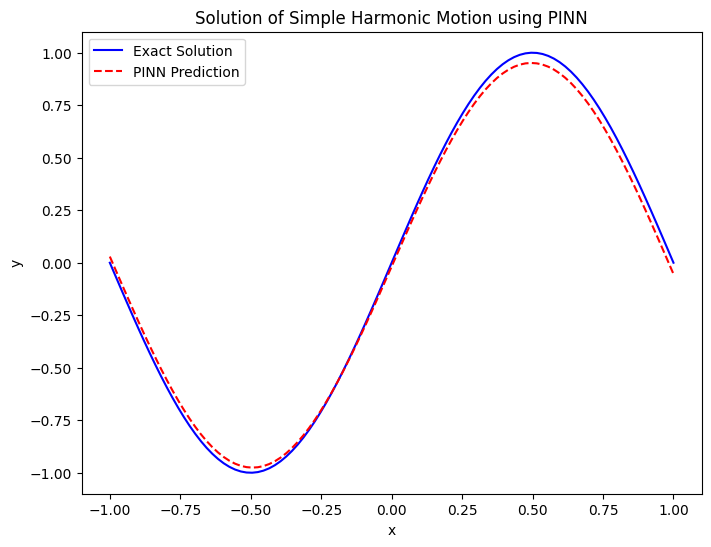

In [361]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_test.numpy(), y_exact, label='Exact Solution', color='blue')
plt.plot(x_test.numpy(), y_pred, label='PINN Prediction', linestyle='dashed', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Solution of Simple Harmonic Motion using PINN')
plt.show()

# Newton's Law of Cooling

In [312]:
# Constants
T_amb = 27
T_0 = 250
k = 0.45

In [329]:
def exact_solution(t):
  return T_amb + (T_0 - T_amb) * np.exp(- k * t)

In [315]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.hidden_layer(x)

def compute_loss_pde(model, t):
  t = t.requires_grad_(True)
  y = model(t)
  dy_dt = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y), create_graph = True)[0]
  return dy_dt - k * (T_amb - y)

def calculate_loss_bce(model):
  return (model(torch.tensor([[0.0]], dtype = torch.float32, device = DEVICE)) - T_0) ** 2

def total_loss(model, t):
  loss_pde = compute_loss_pde(model, t).to(DEVICE)
  loss_bce = calculate_loss_bce(model)
  return torch.mean(loss_pde**2) + loss_bce

In [316]:
def train_pinn(model, optimizer, scheduler, x_train, epochs, patience):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_train)
        loss.backward()
        optimizer.step()

        # Update the learning rate based on loss
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Early stopping condition
        if scheduler.num_bad_epochs >= patience:
            print("Training stopped early due to plateau in learning.")
            break

In [324]:
N_collocation = 100
x_train = torch.rand(N_collocation, 1) * 10
x_train = x_train.to(DEVICE)

In [325]:
# Initialize the model and optimizer
model = PINN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6
)

In [326]:
epochs = 5000
train_pinn(model, optimizer, scheduler, x_train, epochs, patience=1000)

Epoch 0, Loss: 62531.91796875, Learning Rate: 0.01
Epoch 100, Loss: 38840.1875, Learning Rate: 0.01
Epoch 200, Loss: 24746.953125, Learning Rate: 0.01
Epoch 300, Loss: 16444.193359375, Learning Rate: 0.01
Epoch 400, Loss: 11976.431640625, Learning Rate: 0.01
Epoch 500, Loss: 9815.908203125, Learning Rate: 0.01
Epoch 600, Loss: 2979.694580078125, Learning Rate: 0.01
Epoch 700, Loss: 1168.9783935546875, Learning Rate: 0.01
Epoch 800, Loss: 418.1745910644531, Learning Rate: 0.01
Epoch 900, Loss: 135.52711486816406, Learning Rate: 0.01
Epoch 1000, Loss: 39.600250244140625, Learning Rate: 0.01
Epoch 1100, Loss: 10.38957405090332, Learning Rate: 0.01
Epoch 1200, Loss: 2.4389379024505615, Learning Rate: 0.01
Epoch 1300, Loss: 0.5117775797843933, Learning Rate: 0.01
Epoch 1400, Loss: 0.09726343303918839, Learning Rate: 0.01
Epoch 1500, Loss: 0.01833295449614525, Learning Rate: 0.01
Epoch 1600, Loss: 0.004910529591143131, Learning Rate: 0.01
Epoch 1700, Loss: 0.0027032869402319193, Learning Rat

In [330]:
x_test = torch.tensor(np.linspace(0, 10, 100).reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test).detach().numpy()
y_exact = exact_solution(x_test.numpy())

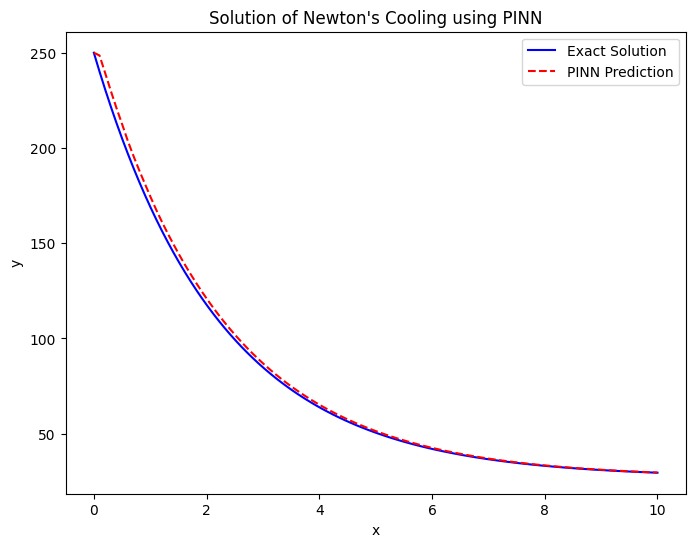

In [333]:
plt.figure(figsize=(8, 6))
plt.plot(x_test.numpy(), y_exact, label='Exact Solution', color='blue')
plt.plot(x_test.numpy(), y_pred, label='PINN Prediction', linestyle='dashed', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Solution of Newton's Cooling using PINN")
plt.show()